# Install some needed library


In [1]:
!pip install --upgrade livelossplot 

# 1- Import libraries

In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets 
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import numpy as np
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import shutil
import tarfile
from scipy.io import loadmat
import timm
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing the data

## 1- uncompress the data

In [3]:
# Extract tar file
tar = tarfile.open('/kaggle/input/flower/102flowers.tgz', 'r:gz')
tar.extractall()
tar.close()

## load the labels and split files 

In [4]:
# Load data
data = loadmat('/kaggle/input/labels/imagelabels.mat')
label = data['labels'].tolist()[0]
splitid=loadmat('/kaggle/input/splitt/setid.mat',squeeze_me=True)
train = (splitid['trnid']).tolist()
test = (splitid['tstid']).tolist()
val = (splitid['valid']).tolist()

## Extract the id from the image name 

for ex: the image image_00980 will be 980 in the extracted_ids variable

In [5]:
folder_path = 'jpg'
file_list = sorted(os.listdir(folder_path))
extracted_ids = []

for filename in file_list:
    if filename.startswith('image_') and filename.endswith('.jpg'):
        # Extracting the ID part and removing leading zeros
        file_id = filename.split('_')[1].split('.')[0].lstrip('0')
        extracted_ids.append(file_id)

# Now, 'extracted_ids' contains the list of extracted IDs
extracted_ids = [int(i) for i in extracted_ids]
print(extracted_ids[:8])

[1, 2, 3, 4, 5, 6, 7, 8]


## make list of tuple between the image id and label
we know that there are 8189 label for 8189 images, we make tuple to make each id with its corresponding label

In [6]:
# create a pair of extracted_id and label
file_id_label = list(zip(extracted_ids, label))

## filter the image according to split intsructions
make list of images that should be in the train set, and so on for test and valid

In [7]:
# see how many image from extracted_ids are in train
train_id = [i for i in extracted_ids if i in train]
test_id = [i for i in extracted_ids if i in test]
val_id = [i for i in extracted_ids if i in val]

## make train test valid dirs

In [8]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('valid')

## move each image into its class in each set

In [9]:
def move_images_to_folder(source_folder, destination_folder, file_id_label, selected_ids):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Move images to the destination folder based on IDs and labels
    for file_id, label in file_id_label:
        if file_id in selected_ids:
            source_path = os.path.join(source_folder, f'image_{file_id:05d}.jpg')  # Assuming images are named like 'image_00001.jpg'
            destination_subfolder = os.path.join(destination_folder, str(label))

            # Create the label subfolder if it doesn't exist
            if not os.path.exists(destination_subfolder):
                os.makedirs(destination_subfolder)

            destination_path = os.path.join(destination_subfolder, f'image_{file_id:05d}.jpg')

            try:
                # Move the file
                shutil.move(source_path, destination_path)
                print(f"Moved image_{file_id:05d}.jpg to {destination_subfolder}")
            except FileNotFoundError as e:
                print(f"Error: {e}")

# Assuming original image folder is 'jpg'
original_folder = 'jpg'

# Move images for train set
move_images_to_folder(original_folder, 'train', file_id_label, train_id)

# Move images for validation set
move_images_to_folder(original_folder, 'valid', file_id_label, val_id)

# Move images for test set
move_images_to_folder(original_folder, 'test', file_id_label, test_id)


Moved image_00028.jpg to train/77
Moved image_00036.jpg to train/77
Moved image_00079.jpg to train/77
Moved image_00116.jpg to train/77
Moved image_00118.jpg to train/77
Moved image_00126.jpg to train/77
Moved image_00144.jpg to train/77
Moved image_00177.jpg to train/77
Moved image_00200.jpg to train/77
Moved image_00216.jpg to train/77
Moved image_00274.jpg to train/73
Moved image_00297.jpg to train/73
Moved image_00319.jpg to train/73
Moved image_00375.jpg to train/73
Moved image_00380.jpg to train/73
Moved image_00383.jpg to train/73
Moved image_00401.jpg to train/73
Moved image_00411.jpg to train/73
Moved image_00442.jpg to train/73
Moved image_00444.jpg to train/73
Moved image_00485.jpg to train/88
Moved image_00487.jpg to train/88
Moved image_00501.jpg to train/88
Moved image_00514.jpg to train/88
Moved image_00534.jpg to train/88
Moved image_00535.jpg to train/88
Moved image_00564.jpg to train/88
Moved image_00576.jpg to train/88
Moved image_00587.jpg to train/88
Moved image_00

In [10]:
!rm -rf /kaggle/working/jpg

# Load the data and prepare it for training
the data is loaded, transformed and agumented. the convenient agumentaions only are applied to avoid black images

In [11]:
# Set the root directory where the dataset will be downloaded
root = '/kaggle/working/'

# Define the transformations to be applied to the images
data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224, padding_mode="reflect", pad_if_needed=True),  # -
            transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10),
            # Apply an horizontal flip with 50% probability (i.e., if you pass
            # 100 images through around half of them will undergo the flipping)
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]),
        "valid": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),  # -
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),  # -
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    }

train_dir = os.path.join(root, 'train')
test_dir = os.path.join(root, 'test')
valid_dir=os.path.join(root, 'valid')

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])


# Create data loaders for train, validation, and test datasets
batch_size = 32
data_loaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
}


## class names
I used names provided by tensorflow just to make it readable

In [12]:
names = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "english marigold",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia?",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen",
    "watercress",
    "canna lily",
    "hippeastrum",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
]

# Visualize some images

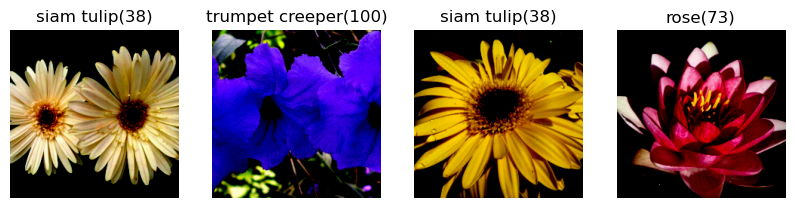

In [13]:
# Get a batch of data from the train_loader
dataiter = next(iter(data_loaders['test']))
images, labels = dataiter

# Plot multiple images from the batch
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Select a single image from the batch
    image = images[i]

    # Reshape the image to (height, width, num_channels)
    image = np.transpose(image, (1, 2, 0))

    # Display the image and label
    ax.imshow(image)
    ax.set_title(f"{names[labels[i]]}({labels[i]})")
    ax.axis("off")

plt.show()


# Loading the model

 the model is loaded 

In [14]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [15]:
model = timm.create_model("convformer_s18", pretrained=True,num_classes=102)
model

MetaFormer(
  (stem): Stem(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (norm): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): MetaFormerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): MetaFormerBlock(
          (norm1): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
          (token_mixer): SepConv(
            (pwconv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (act1): StarReLU(
              (relu): ReLU()
            )
            (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128, bias=False)
            (act2): Identity()
            (pwconv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (drop_path1): Identity()
          (layer_scale1): Identity()
          (res_scale1): Identity()
          (norm2): LayerNorm2dNoBias((64,), eps=1e-06, e

In [16]:
frozen_parameters = []

for p in model.parameters():
    # Freeze only parameters that are not already frozen
    # (if any)
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)

print(f"Froze {len(frozen_parameters)} groups of parameters")

# Now let's thaw the parameters of the head we have
# added
for p in model.head.parameters():
    p.requires_grad = True



Froze 242 groups of parameters


# Helper functions for training
  helpers are some functions that will help us in training our model smoothly and achieving the best loss value on validation set

In [17]:
loss = nn.CrossEntropyLoss()


In [18]:
def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs one train_one_epoch epoch
    """

    if torch.cuda.is_available():
        # YOUR CODE HERE: transfer the model to the GPU
        # HINT: use .cuda()
        model.cuda()

    # YOUR CODE HERE: set the model to training mode
    train_loss = 0.0
    model.train()

    for batch_idx, (data, target) in tqdm(
            enumerate(train_dataloader),
            desc="Training",
            total=len(train_dataloader),
            leave=True,
            ncols=80,
    ):
        # move data to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # 1. clear the gradients of all optimized variables
        model.zero_grad()
        # 2. forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # 3. calculate the loss
        loss_value = loss(output, target)
        # 4. backward pass: compute gradient of the loss with respect to model parameters
        loss_value.backward()
        # 5. perform a single optimization step (parameter update)
        optimizer.step()
        # update average training loss
        train_loss = train_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )

    return train_loss


def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """

    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        if torch.cuda.is_available():
            model.cuda()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
                enumerate(valid_dataloader),
                desc="Validating",
                total=len(valid_dataloader),
                leave=True,
                ncols=80,
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # 2. calculate the loss
            loss_value = loss(output, target)

            # Calculate average validation loss
            valid_loss = valid_loss + (
                    (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )

    return valid_loss

In [19]:
def get_optimizer(
    model: nn.Module,
    optimizer: str = "SGD",
    learning_rate: float = 0.01,
    momentum: float = 0.5,
    weight_decay: float = 0,
):
    """
    Returns an optimizer instance

    :param model: the model to optimize
    :param optimizer: one of 'SGD' or 'Adam'
    :param learning_rate: the learning rate
    :param momentum: the momentum (if the optimizer uses it)
    :param weight_decay: regularization coefficient
    """
    if optimizer.lower() == "sgd":
        # YOUR CODE HERE: create an instance of the SGD
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.SGD(
            model.parameters(),
            lr=learning_rate,
            momentum=momentum,
            weight_decay=weight_decay




        )

    elif optimizer.lower() == "adam":
        # YOUR CODE HERE: create an instance of the Adam
        # optimizer. Use the input parameters learning_rate, momentum
        # and weight_decay
        opt = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
    else:
        raise ValueError(f"Optimizer {optimizer} not supported")

    return opt
def optimize(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a
    # plateau
    # HINT: look here: 
    # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    scheduler  =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            print(f"New minimum validation loss: {valid_loss:.6f}. Saving model ...")

            # Save the weights to save_path
            torch.save(model.state_dict(), 'model.pth')

            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        scheduler.step(valid_loss)
        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

In [20]:
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])


# Training and testing
 I choosed paramteres and schduler adjust lr if needed

In [21]:
num_epochs = 10  # number of epochs for training
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4 # regularization. Increase this to combat overfitting

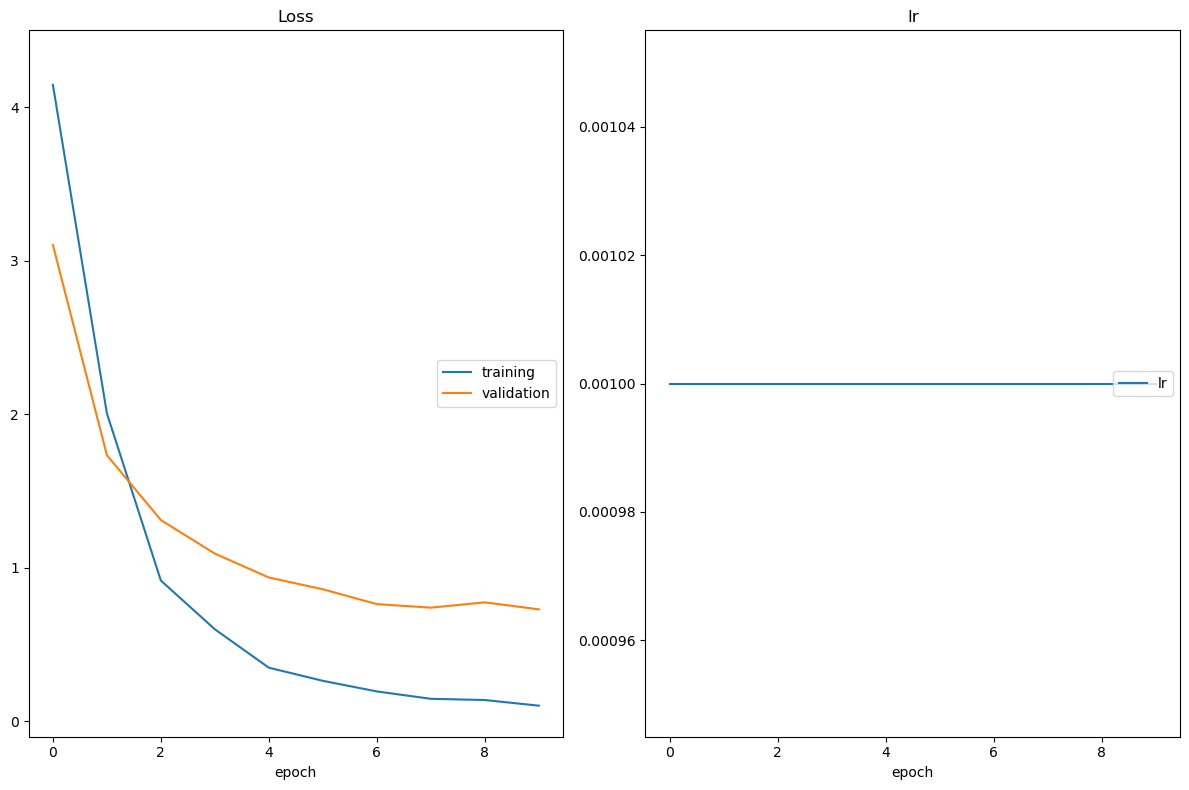

In [22]:
# train the model
optimizer = get_optimizer(
    model,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True)

In [23]:
def one_epoch_test(test_dataloader, model, loss):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        if torch.cuda.is_available():
            model = model.cuda()

        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            logits  = model(data)
            print('no error after feed')
            # 2. calculate the loss
            loss_value  = loss(logits,target)

            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))

            # convert logits to predicted class
            # HINT: the predicted class is the index of the max of the logits
            pred  = logits.data.max(1, keepdim=True)[1]

            # compare predictions to true label
            correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
            total += data.size(0)

            print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return test_loss

In [24]:
one_epoch_test(data_loaders['test'], model, loss)

Testing:   1%|▏                                 | 1/193 [00:00<01:01,  3.10it/s]

no error after feed
Test Loss: 1.412805



Testing:   1%|▎                                 | 2/193 [00:00<01:01,  3.10it/s]

no error after feed
Test Loss: 1.128622



Testing:   2%|▌                                 | 3/193 [00:00<01:01,  3.10it/s]

no error after feed
Test Loss: 1.036517



Testing:   2%|▋                                 | 4/193 [00:01<01:01,  3.07it/s]

no error after feed
Test Loss: 0.976584



Testing:   3%|▉                                 | 5/193 [00:01<01:01,  3.07it/s]

no error after feed
Test Loss: 0.905754



Testing:   3%|█                                 | 6/193 [00:01<01:01,  3.06it/s]

no error after feed
Test Loss: 0.834903



Testing:   4%|█▏                                | 7/193 [00:02<01:00,  3.08it/s]

no error after feed
Test Loss: 0.801520



Testing:   4%|█▍                                | 8/193 [00:02<01:00,  3.08it/s]

no error after feed
Test Loss: 0.912896



Testing:   5%|█▌                                | 9/193 [00:02<00:59,  3.08it/s]

no error after feed
Test Loss: 0.868764



Testing:   5%|█▋                               | 10/193 [00:03<00:59,  3.09it/s]

no error after feed
Test Loss: 0.872007



Testing:   6%|█▉                               | 11/193 [00:03<01:02,  2.93it/s]

no error after feed
Test Loss: 0.858780



Testing:   6%|██                               | 12/193 [00:04<01:05,  2.78it/s]

no error after feed
Test Loss: 0.908923



Testing:   7%|██▏                              | 13/193 [00:04<01:03,  2.82it/s]

no error after feed
Test Loss: 0.892237



Testing:   7%|██▍                              | 14/193 [00:04<01:01,  2.89it/s]

no error after feed
Test Loss: 0.862496



Testing:   8%|██▌                              | 15/193 [00:05<01:01,  2.90it/s]

no error after feed
Test Loss: 0.843423



Testing:   8%|██▋                              | 16/193 [00:05<00:59,  2.97it/s]

no error after feed
Test Loss: 0.858241

no error after feed


Testing:   9%|██▉                              | 17/193 [00:05<00:58,  3.01it/s]

Test Loss: 0.856193

no error after feed


Testing:   9%|███                              | 18/193 [00:05<00:57,  3.04it/s]

Test Loss: 0.844499



Testing:  10%|███▏                             | 19/193 [00:06<00:57,  3.04it/s]

no error after feed
Test Loss: 0.839567



Testing:  10%|███▍                             | 20/193 [00:06<00:56,  3.05it/s]

no error after feed
Test Loss: 0.860856

no error after feed


Testing:  11%|███▌                             | 21/193 [00:06<00:56,  3.07it/s]

Test Loss: 0.865485

no error after feed


Testing:  11%|███▊                             | 22/193 [00:07<00:55,  3.07it/s]

Test Loss: 0.877558

no error after feed


Testing:  12%|███▉                             | 23/193 [00:07<00:55,  3.09it/s]

Test Loss: 0.887356

no error after feed


Testing:  12%|████                             | 24/193 [00:07<00:54,  3.09it/s]

Test Loss: 0.871401

no error after feed


Testing:  13%|████▎                            | 25/193 [00:08<00:54,  3.09it/s]

Test Loss: 0.858475

no error after feed


Testing:  13%|████▍                            | 26/193 [00:08<00:53,  3.11it/s]

Test Loss: 0.872266

no error after feed


Testing:  14%|████▌                            | 27/193 [00:08<00:53,  3.10it/s]

Test Loss: 0.868461

no error after feed


Testing:  15%|████▊                            | 28/193 [00:09<00:53,  3.10it/s]

Test Loss: 0.861679

no error after feed


Testing:  15%|████▉                            | 29/193 [00:09<00:52,  3.10it/s]

Test Loss: 0.868386



Testing:  16%|█████▏                           | 30/193 [00:09<00:52,  3.08it/s]

no error after feed
Test Loss: 0.875069



Testing:  16%|█████▎                           | 31/193 [00:10<00:52,  3.09it/s]

no error after feed
Test Loss: 0.867404



Testing:  17%|█████▍                           | 32/193 [00:10<00:51,  3.10it/s]

no error after feed
Test Loss: 0.861365



Testing:  17%|█████▋                           | 33/193 [00:10<00:51,  3.10it/s]

no error after feed
Test Loss: 0.850702



Testing:  18%|█████▊                           | 34/193 [00:11<00:51,  3.12it/s]

no error after feed
Test Loss: 0.845917



Testing:  18%|█████▉                           | 35/193 [00:11<00:50,  3.12it/s]

no error after feed
Test Loss: 0.846236



Testing:  19%|██████▏                          | 36/193 [00:11<00:50,  3.12it/s]

no error after feed
Test Loss: 0.839025



Testing:  19%|██████▎                          | 37/193 [00:12<00:49,  3.13it/s]

no error after feed
Test Loss: 0.832607



Testing:  20%|██████▍                          | 38/193 [00:12<00:49,  3.13it/s]

no error after feed
Test Loss: 0.828075



Testing:  20%|██████▋                          | 39/193 [00:12<00:49,  3.14it/s]

no error after feed
Test Loss: 0.822269



Testing:  21%|██████▊                          | 40/193 [00:13<00:48,  3.13it/s]

no error after feed
Test Loss: 0.816041



Testing:  21%|███████                          | 41/193 [00:13<00:48,  3.12it/s]

no error after feed
Test Loss: 0.820394



Testing:  22%|███████▏                         | 42/193 [00:13<00:48,  3.12it/s]

no error after feed
Test Loss: 0.813647



Testing:  22%|███████▎                         | 43/193 [00:14<00:48,  3.11it/s]

no error after feed
Test Loss: 0.813752



Testing:  23%|███████▌                         | 44/193 [00:14<00:47,  3.10it/s]

no error after feed
Test Loss: 0.813702



Testing:  23%|███████▋                         | 45/193 [00:14<00:47,  3.10it/s]

no error after feed
Test Loss: 0.814459



Testing:  24%|███████▊                         | 46/193 [00:15<00:48,  3.04it/s]

no error after feed
Test Loss: 0.814397



Testing:  24%|████████                         | 47/193 [00:15<00:47,  3.05it/s]

no error after feed
Test Loss: 0.818578



Testing:  25%|████████▏                        | 48/193 [00:15<00:47,  3.07it/s]

no error after feed
Test Loss: 0.820585



Testing:  25%|████████▍                        | 49/193 [00:16<00:46,  3.08it/s]

no error after feed
Test Loss: 0.819636



Testing:  26%|████████▌                        | 50/193 [00:16<00:46,  3.08it/s]

no error after feed
Test Loss: 0.820906



Testing:  26%|████████▋                        | 51/193 [00:16<00:45,  3.09it/s]

no error after feed
Test Loss: 0.820290



Testing:  27%|████████▉                        | 52/193 [00:16<00:45,  3.11it/s]

no error after feed
Test Loss: 0.818445



Testing:  27%|█████████                        | 53/193 [00:17<00:44,  3.11it/s]

no error after feed
Test Loss: 0.821266



Testing:  28%|█████████▏                       | 54/193 [00:17<00:44,  3.12it/s]

no error after feed
Test Loss: 0.817198



Testing:  28%|█████████▍                       | 55/193 [00:17<00:44,  3.12it/s]

no error after feed
Test Loss: 0.814079



Testing:  29%|█████████▌                       | 56/193 [00:18<00:44,  3.10it/s]

no error after feed
Test Loss: 0.816445

no error after feed


Testing:  30%|█████████▋                       | 57/193 [00:18<00:43,  3.12it/s]

Test Loss: 0.820558

no error after feed


Testing:  30%|█████████▉                       | 58/193 [00:18<00:43,  3.13it/s]

Test Loss: 0.817525

no error after feed


Testing:  31%|██████████                       | 59/193 [00:19<00:43,  3.11it/s]

Test Loss: 0.819234

no error after feed


Testing:  31%|██████████▎                      | 60/193 [00:19<00:42,  3.13it/s]

Test Loss: 0.814014

no error after feed


Testing:  32%|██████████▍                      | 61/193 [00:19<00:42,  3.13it/s]

Test Loss: 0.805869



Testing:  32%|██████████▌                      | 62/193 [00:20<00:42,  3.08it/s]

no error after feed
Test Loss: 0.807357



Testing:  33%|██████████▊                      | 63/193 [00:20<00:42,  3.07it/s]

no error after feed
Test Loss: 0.805329



Testing:  33%|██████████▉                      | 64/193 [00:20<00:42,  3.06it/s]

no error after feed
Test Loss: 0.803193



Testing:  34%|███████████                      | 65/193 [00:21<00:41,  3.08it/s]

no error after feed
Test Loss: 0.804437



Testing:  34%|███████████▎                     | 66/193 [00:21<00:41,  3.10it/s]

no error after feed
Test Loss: 0.819666



Testing:  35%|███████████▍                     | 67/193 [00:21<00:40,  3.10it/s]

no error after feed
Test Loss: 0.814320



Testing:  35%|███████████▋                     | 68/193 [00:22<00:40,  3.12it/s]

no error after feed
Test Loss: 0.818202



Testing:  36%|███████████▊                     | 69/193 [00:22<00:39,  3.14it/s]

no error after feed
Test Loss: 0.825469



Testing:  36%|███████████▉                     | 70/193 [00:22<00:39,  3.14it/s]

no error after feed
Test Loss: 0.821811



Testing:  37%|████████████▏                    | 71/193 [00:23<00:38,  3.14it/s]

no error after feed
Test Loss: 0.821014



Testing:  37%|████████████▎                    | 72/193 [00:23<00:38,  3.13it/s]

no error after feed
Test Loss: 0.818484



Testing:  38%|████████████▍                    | 73/193 [00:23<00:38,  3.13it/s]

no error after feed
Test Loss: 0.819589



Testing:  38%|████████████▋                    | 74/193 [00:24<00:38,  3.13it/s]

no error after feed
Test Loss: 0.818140



Testing:  39%|████████████▊                    | 75/193 [00:24<00:37,  3.13it/s]

no error after feed
Test Loss: 0.818872



Testing:  39%|████████████▉                    | 76/193 [00:24<00:37,  3.13it/s]

no error after feed
Test Loss: 0.819035



Testing:  40%|█████████████▏                   | 77/193 [00:25<00:37,  3.06it/s]

no error after feed
Test Loss: 0.819181



Testing:  40%|█████████████▎                   | 78/193 [00:25<00:37,  3.08it/s]

no error after feed
Test Loss: 0.825093



Testing:  41%|█████████████▌                   | 79/193 [00:25<00:36,  3.09it/s]

no error after feed
Test Loss: 0.827530



Testing:  41%|█████████████▋                   | 80/193 [00:25<00:36,  3.10it/s]

no error after feed
Test Loss: 0.822604



Testing:  42%|█████████████▊                   | 81/193 [00:26<00:35,  3.11it/s]

no error after feed
Test Loss: 0.827418



Testing:  42%|██████████████                   | 82/193 [00:26<00:35,  3.13it/s]

no error after feed
Test Loss: 0.822495



Testing:  43%|██████████████▏                  | 83/193 [00:26<00:35,  3.14it/s]

no error after feed
Test Loss: 0.824824



Testing:  44%|██████████████▎                  | 84/193 [00:27<00:34,  3.13it/s]

no error after feed
Test Loss: 0.826354



Testing:  44%|██████████████▌                  | 85/193 [00:27<00:34,  3.11it/s]

no error after feed
Test Loss: 0.828210



Testing:  45%|██████████████▋                  | 86/193 [00:27<00:34,  3.10it/s]

no error after feed
Test Loss: 0.823436



Testing:  45%|██████████████▉                  | 87/193 [00:28<00:34,  3.11it/s]

no error after feed
Test Loss: 0.822167



Testing:  46%|███████████████                  | 88/193 [00:28<00:33,  3.12it/s]

no error after feed
Test Loss: 0.825970



Testing:  46%|███████████████▏                 | 89/193 [00:28<00:33,  3.12it/s]

no error after feed
Test Loss: 0.828286



Testing:  47%|███████████████▍                 | 90/193 [00:29<00:33,  3.12it/s]

no error after feed
Test Loss: 0.829301

no error after feed


Testing:  47%|███████████████▌                 | 91/193 [00:29<00:32,  3.11it/s]

Test Loss: 0.826579

no error after feed


Testing:  48%|███████████████▋                 | 92/193 [00:29<00:32,  3.12it/s]

Test Loss: 0.828865

no error after feed


Testing:  48%|███████████████▉                 | 93/193 [00:30<00:32,  3.12it/s]

Test Loss: 0.825879

no error after feed


Testing:  49%|████████████████                 | 94/193 [00:30<00:31,  3.12it/s]

Test Loss: 0.824419



Testing:  49%|████████████████▏                | 95/193 [00:30<00:31,  3.09it/s]

no error after feed
Test Loss: 0.828249



Testing:  50%|████████████████▍                | 96/193 [00:31<00:31,  3.07it/s]

no error after feed
Test Loss: 0.823924



Testing:  50%|████████████████▌                | 97/193 [00:31<00:31,  3.06it/s]

no error after feed
Test Loss: 0.823465



Testing:  51%|████████████████▊                | 98/193 [00:31<00:30,  3.09it/s]

no error after feed
Test Loss: 0.825994



Testing:  51%|████████████████▉                | 99/193 [00:32<00:30,  3.10it/s]

no error after feed
Test Loss: 0.827846



Testing:  52%|████████████████▌               | 100/193 [00:32<00:29,  3.11it/s]

no error after feed
Test Loss: 0.824754



Testing:  52%|████████████████▋               | 101/193 [00:32<00:29,  3.10it/s]

no error after feed
Test Loss: 0.824487



Testing:  53%|████████████████▉               | 102/193 [00:33<00:29,  3.09it/s]

no error after feed
Test Loss: 0.822515



Testing:  53%|█████████████████               | 103/193 [00:33<00:29,  3.10it/s]

no error after feed
Test Loss: 0.819899



Testing:  54%|█████████████████▏              | 104/193 [00:33<00:28,  3.10it/s]

no error after feed
Test Loss: 0.821315



Testing:  54%|█████████████████▍              | 105/193 [00:34<00:28,  3.10it/s]

no error after feed
Test Loss: 0.818060



Testing:  55%|█████████████████▌              | 106/193 [00:34<00:28,  3.10it/s]

no error after feed
Test Loss: 0.816521



Testing:  55%|█████████████████▋              | 107/193 [00:34<00:27,  3.10it/s]

no error after feed
Test Loss: 0.819743



Testing:  56%|█████████████████▉              | 108/193 [00:35<00:28,  2.98it/s]

no error after feed
Test Loss: 0.816068



Testing:  56%|██████████████████              | 109/193 [00:35<00:28,  2.91it/s]

no error after feed
Test Loss: 0.812368



Testing:  57%|██████████████████▏             | 110/193 [00:35<00:28,  2.88it/s]

no error after feed
Test Loss: 0.812142



Testing:  58%|██████████████████▍             | 111/193 [00:36<00:27,  2.94it/s]

no error after feed
Test Loss: 0.811690



Testing:  58%|██████████████████▌             | 112/193 [00:36<00:27,  2.99it/s]

no error after feed
Test Loss: 0.810687



Testing:  59%|██████████████████▋             | 113/193 [00:36<00:26,  3.01it/s]

no error after feed
Test Loss: 0.811615

no error after feed


Testing:  59%|██████████████████▉             | 114/193 [00:37<00:26,  3.03it/s]

Test Loss: 0.810750

no error after feed


Testing:  60%|███████████████████             | 115/193 [00:37<00:25,  3.06it/s]

Test Loss: 0.811835

no error after feed


Testing:  60%|███████████████████▏            | 116/193 [00:37<00:25,  3.08it/s]

Test Loss: 0.809180

no error after feed


Testing:  61%|███████████████████▍            | 117/193 [00:37<00:24,  3.10it/s]

Test Loss: 0.812440

no error after feed


Testing:  61%|███████████████████▌            | 118/193 [00:38<00:24,  3.10it/s]

Test Loss: 0.814630

no error after feed


Testing:  62%|███████████████████▋            | 119/193 [00:38<00:23,  3.12it/s]

Test Loss: 0.813346

no error after feed


Testing:  62%|███████████████████▉            | 120/193 [00:38<00:23,  3.12it/s]

Test Loss: 0.815057

no error after feed


Testing:  63%|████████████████████            | 121/193 [00:39<00:23,  3.11it/s]

Test Loss: 0.814210

no error after feed


Testing:  63%|████████████████████▏           | 122/193 [00:39<00:22,  3.12it/s]

Test Loss: 0.818346



Testing:  64%|████████████████████▍           | 123/193 [00:39<00:22,  3.10it/s]

no error after feed
Test Loss: 0.818922



Testing:  64%|████████████████████▌           | 124/193 [00:40<00:22,  3.08it/s]

no error after feed
Test Loss: 0.815566



Testing:  65%|████████████████████▋           | 125/193 [00:40<00:21,  3.09it/s]

no error after feed
Test Loss: 0.813739



Testing:  65%|████████████████████▉           | 126/193 [00:40<00:21,  3.09it/s]

no error after feed
Test Loss: 0.812709



Testing:  66%|█████████████████████           | 127/193 [00:41<00:21,  3.08it/s]

no error after feed
Test Loss: 0.810972



Testing:  66%|█████████████████████▏          | 128/193 [00:41<00:21,  3.08it/s]

no error after feed
Test Loss: 0.809508



Testing:  67%|█████████████████████▍          | 129/193 [00:41<00:20,  3.08it/s]

no error after feed
Test Loss: 0.808509



Testing:  67%|█████████████████████▌          | 130/193 [00:42<00:20,  3.08it/s]

no error after feed
Test Loss: 0.809213



Testing:  68%|█████████████████████▋          | 131/193 [00:42<00:20,  3.09it/s]

no error after feed
Test Loss: 0.809193



Testing:  68%|█████████████████████▉          | 132/193 [00:42<00:19,  3.10it/s]

no error after feed
Test Loss: 0.807978



Testing:  69%|██████████████████████          | 133/193 [00:43<00:19,  3.09it/s]

no error after feed
Test Loss: 0.807212



Testing:  69%|██████████████████████▏         | 134/193 [00:43<00:19,  3.09it/s]

no error after feed
Test Loss: 0.807196

no error after feed


Testing:  70%|██████████████████████▍         | 135/193 [00:43<00:18,  3.11it/s]

Test Loss: 0.808128

no error after feed


Testing:  70%|██████████████████████▌         | 136/193 [00:44<00:18,  3.11it/s]

Test Loss: 0.807798

no error after feed


Testing:  71%|██████████████████████▋         | 137/193 [00:44<00:18,  3.11it/s]

Test Loss: 0.807229



Testing:  72%|██████████████████████▉         | 138/193 [00:44<00:17,  3.10it/s]

no error after feed
Test Loss: 0.808923



Testing:  72%|███████████████████████         | 139/193 [00:45<00:17,  3.09it/s]

no error after feed
Test Loss: 0.811107



Testing:  73%|███████████████████████▏        | 140/193 [00:45<00:17,  3.11it/s]

no error after feed
Test Loss: 0.816005



Testing:  73%|███████████████████████▍        | 141/193 [00:45<00:16,  3.09it/s]

no error after feed
Test Loss: 0.813858

no error after feed


Testing:  74%|███████████████████████▌        | 142/193 [00:46<00:16,  3.11it/s]

Test Loss: 0.814424

no error after feed


Testing:  74%|███████████████████████▋        | 143/193 [00:46<00:16,  3.12it/s]

Test Loss: 0.813365

no error after feed


Testing:  75%|███████████████████████▉        | 144/193 [00:46<00:15,  3.12it/s]

Test Loss: 0.814549

no error after feed


Testing:  75%|████████████████████████        | 145/193 [00:47<00:15,  3.10it/s]

Test Loss: 0.815571

no error after feed


Testing:  76%|████████████████████████▏       | 146/193 [00:47<00:15,  3.11it/s]

Test Loss: 0.819477

no error after feed


Testing:  76%|████████████████████████▎       | 147/193 [00:47<00:14,  3.14it/s]

Test Loss: 0.820159

no error after feed


Testing:  77%|████████████████████████▌       | 148/193 [00:47<00:14,  3.13it/s]

Test Loss: 0.822563

no error after feed


Testing:  77%|████████████████████████▋       | 149/193 [00:48<00:14,  3.14it/s]

Test Loss: 0.823462

no error after feed


Testing:  78%|████████████████████████▊       | 150/193 [00:48<00:13,  3.14it/s]

Test Loss: 0.821443

no error after feed


Testing:  78%|█████████████████████████       | 151/193 [00:48<00:13,  3.14it/s]

Test Loss: 0.821721

no error after feed


Testing:  79%|█████████████████████████▏      | 152/193 [00:49<00:13,  3.12it/s]

Test Loss: 0.821706

no error after feed


Testing:  79%|█████████████████████████▎      | 153/193 [00:49<00:12,  3.10it/s]

Test Loss: 0.819549

no error after feed


Testing:  80%|█████████████████████████▌      | 154/193 [00:49<00:12,  3.11it/s]

Test Loss: 0.819156



Testing:  80%|█████████████████████████▋      | 155/193 [00:50<00:12,  3.02it/s]

no error after feed
Test Loss: 0.817669



Testing:  81%|█████████████████████████▊      | 156/193 [00:50<00:12,  3.02it/s]

no error after feed
Test Loss: 0.815358

no error after feed


Testing:  81%|██████████████████████████      | 157/193 [00:50<00:11,  3.05it/s]

Test Loss: 0.815525

no error after feed


Testing:  82%|██████████████████████████▏     | 158/193 [00:51<00:11,  3.07it/s]

Test Loss: 0.815333

no error after feed


Testing:  82%|██████████████████████████▎     | 159/193 [00:51<00:11,  3.07it/s]

Test Loss: 0.818027

no error after feed


Testing:  83%|██████████████████████████▌     | 160/193 [00:51<00:10,  3.08it/s]

Test Loss: 0.820109

no error after feed


Testing:  83%|██████████████████████████▋     | 161/193 [00:52<00:10,  3.09it/s]

Test Loss: 0.819584



Testing:  84%|██████████████████████████▊     | 162/193 [00:52<00:10,  3.07it/s]

no error after feed
Test Loss: 0.822201



Testing:  84%|███████████████████████████     | 163/193 [00:52<00:09,  3.09it/s]

no error after feed
Test Loss: 0.824025



Testing:  85%|███████████████████████████▏    | 164/193 [00:53<00:09,  3.09it/s]

no error after feed
Test Loss: 0.822204



Testing:  85%|███████████████████████████▎    | 165/193 [00:53<00:09,  3.08it/s]

no error after feed
Test Loss: 0.824191



Testing:  86%|███████████████████████████▌    | 166/193 [00:53<00:08,  3.08it/s]

no error after feed
Test Loss: 0.822753



Testing:  87%|███████████████████████████▋    | 167/193 [00:54<00:08,  3.10it/s]

no error after feed
Test Loss: 0.823899



Testing:  87%|███████████████████████████▊    | 168/193 [00:54<00:08,  3.11it/s]

no error after feed
Test Loss: 0.823078



Testing:  88%|████████████████████████████    | 169/193 [00:54<00:07,  3.10it/s]

no error after feed
Test Loss: 0.821027

no error after feed


Testing:  88%|████████████████████████████▏   | 170/193 [00:55<00:07,  3.11it/s]

Test Loss: 0.821372

no error after feed


Testing:  89%|████████████████████████████▎   | 171/193 [00:55<00:07,  3.12it/s]

Test Loss: 0.822092

no error after feed


Testing:  89%|████████████████████████████▌   | 172/193 [00:55<00:06,  3.14it/s]

Test Loss: 0.820362



Testing:  90%|████████████████████████████▋   | 173/193 [00:56<00:06,  3.11it/s]

no error after feed
Test Loss: 0.819365



Testing:  90%|████████████████████████████▊   | 174/193 [00:56<00:06,  3.12it/s]

no error after feed
Test Loss: 0.819780



Testing:  91%|█████████████████████████████   | 175/193 [00:56<00:05,  3.13it/s]

no error after feed
Test Loss: 0.819437

no error after feed


Testing:  91%|█████████████████████████████▏  | 176/193 [00:57<00:05,  3.12it/s]

Test Loss: 0.818483

no error after feed


Testing:  92%|█████████████████████████████▎  | 177/193 [00:57<00:05,  3.12it/s]

Test Loss: 0.816718

no error after feed


Testing:  92%|█████████████████████████████▌  | 178/193 [00:57<00:04,  3.12it/s]

Test Loss: 0.815973

no error after feed


Testing:  93%|█████████████████████████████▋  | 179/193 [00:57<00:04,  3.11it/s]

Test Loss: 0.815370

no error after feed


Testing:  93%|█████████████████████████████▊  | 180/193 [00:58<00:04,  3.12it/s]

Test Loss: 0.815599

no error after feed


Testing:  94%|██████████████████████████████  | 181/193 [00:58<00:03,  3.13it/s]

Test Loss: 0.813769

no error after feed


Testing:  94%|██████████████████████████████▏ | 182/193 [00:58<00:03,  3.13it/s]

Test Loss: 0.815843

no error after feed


Testing:  95%|██████████████████████████████▎ | 183/193 [00:59<00:03,  3.14it/s]

Test Loss: 0.816134

no error after feed


Testing:  95%|██████████████████████████████▌ | 184/193 [00:59<00:02,  3.15it/s]

Test Loss: 0.814523

no error after feed


Testing:  96%|██████████████████████████████▋ | 185/193 [00:59<00:02,  3.14it/s]

Test Loss: 0.814112

no error after feed


Testing:  96%|██████████████████████████████▊ | 186/193 [01:00<00:02,  3.14it/s]

Test Loss: 0.815564

no error after feed


Testing:  97%|███████████████████████████████ | 187/193 [01:00<00:01,  3.14it/s]

Test Loss: 0.819425

no error after feed


Testing:  97%|███████████████████████████████▏| 188/193 [01:00<00:01,  3.14it/s]

Test Loss: 0.819341

no error after feed


Testing:  98%|███████████████████████████████▎| 189/193 [01:01<00:01,  3.15it/s]

Test Loss: 0.819325

no error after feed


Testing:  98%|███████████████████████████████▌| 190/193 [01:01<00:00,  3.13it/s]

Test Loss: 0.819940

no error after feed


Testing:  99%|███████████████████████████████▋| 191/193 [01:01<00:00,  3.13it/s]

Test Loss: 0.818809

no error after feed


Testing: 100%|████████████████████████████████| 193/193 [01:02<00:00,  3.10it/s]

Test Loss: 0.817926

no error after feed
Test Loss: 0.820055


Test Accuracy: 78% (4831/6149)


0.8200547434196572

# Thaw the Backbone 
I choosed to thaw the backbone and change some hyper parameters, I choosed smaller lr

In [25]:
# Thaw parameters we had frozen before
for p in frozen_parameters:
    p.requires_grad = True

In [26]:
num_epochs = 20  # number of epochs for training
learning_rate = 0.001/100  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 1e-5 # regularization. Increase this to combat overfitting

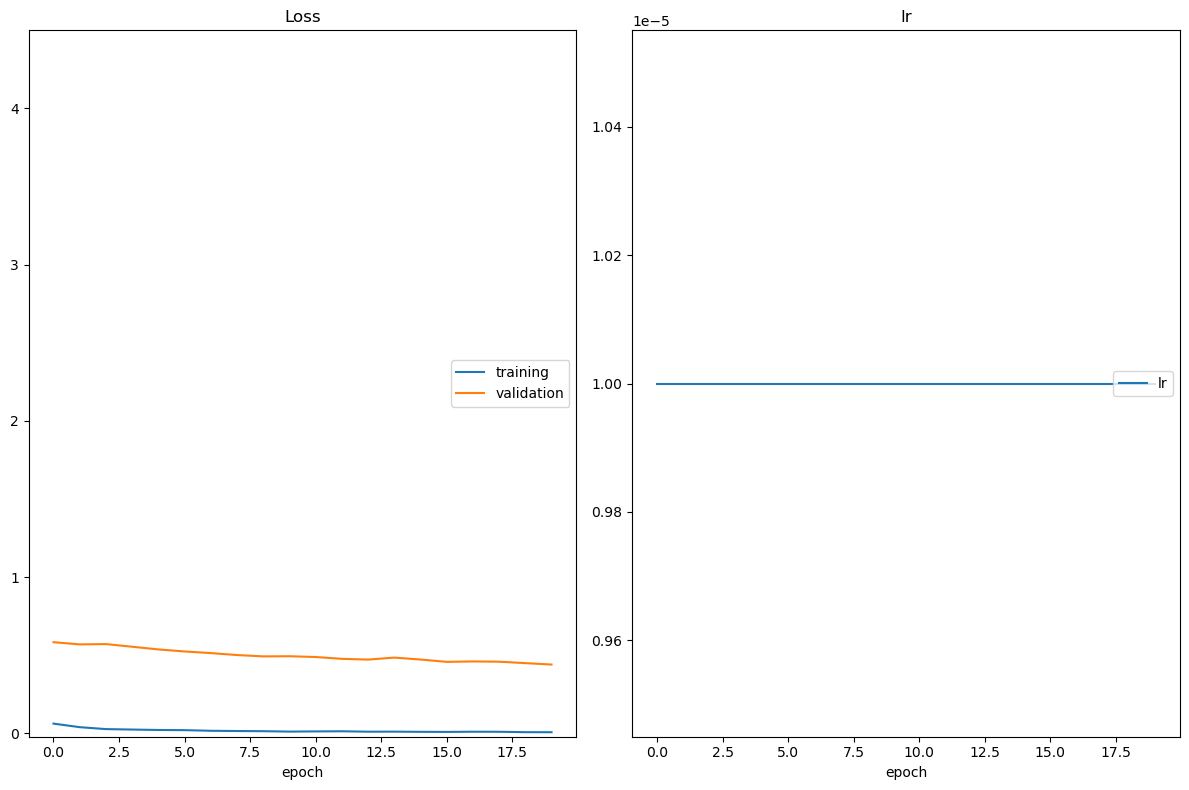

In [27]:
# train the model
optimizer = get_optimizer(
    model,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True)

In [28]:
one_epoch_test(data_loaders['test'], model, loss)

Testing:   1%|▏                                 | 1/193 [00:00<01:09,  2.78it/s]

no error after feed
Test Loss: 0.822534



Testing:   1%|▎                                 | 2/193 [00:00<01:04,  2.95it/s]

no error after feed
Test Loss: 0.616055



Testing:   2%|▌                                 | 3/193 [00:01<01:03,  3.01it/s]

no error after feed
Test Loss: 0.545146



Testing:   2%|▋                                 | 4/193 [00:01<01:01,  3.05it/s]

no error after feed
Test Loss: 0.493142



Testing:   3%|▉                                 | 5/193 [00:01<01:01,  3.07it/s]

no error after feed
Test Loss: 0.515437



Testing:   3%|█                                 | 6/193 [00:01<01:00,  3.09it/s]

no error after feed
Test Loss: 0.487841



Testing:   4%|█▏                                | 7/193 [00:02<00:59,  3.10it/s]

no error after feed
Test Loss: 0.480471



Testing:   4%|█▍                                | 8/193 [00:02<00:59,  3.11it/s]

no error after feed
Test Loss: 0.466767



Testing:   5%|█▌                                | 9/193 [00:02<00:59,  3.10it/s]

no error after feed
Test Loss: 0.438191



Testing:   5%|█▋                               | 10/193 [00:03<00:58,  3.10it/s]

no error after feed
Test Loss: 0.431374



Testing:   6%|█▉                               | 11/193 [00:03<00:58,  3.10it/s]

no error after feed
Test Loss: 0.428037



Testing:   6%|██                               | 12/193 [00:03<00:58,  3.10it/s]

no error after feed
Test Loss: 0.431504



Testing:   7%|██▏                              | 13/193 [00:04<00:57,  3.12it/s]

no error after feed
Test Loss: 0.446554



Testing:   7%|██▍                              | 14/193 [00:04<00:57,  3.11it/s]

no error after feed
Test Loss: 0.437186



Testing:   8%|██▌                              | 15/193 [00:04<00:56,  3.12it/s]

no error after feed
Test Loss: 0.425289



Testing:   8%|██▋                              | 16/193 [00:05<00:56,  3.11it/s]

no error after feed
Test Loss: 0.430148



Testing:   9%|██▉                              | 17/193 [00:05<00:56,  3.12it/s]

no error after feed
Test Loss: 0.417544



Testing:   9%|███                              | 18/193 [00:05<00:56,  3.11it/s]

no error after feed
Test Loss: 0.430026



Testing:  10%|███▏                             | 19/193 [00:06<00:55,  3.12it/s]

no error after feed
Test Loss: 0.430719



Testing:  10%|███▍                             | 20/193 [00:06<00:55,  3.14it/s]

no error after feed
Test Loss: 0.429780



Testing:  11%|███▌                             | 21/193 [00:06<00:54,  3.14it/s]

no error after feed
Test Loss: 0.428550



Testing:  11%|███▊                             | 22/193 [00:07<00:55,  3.05it/s]

no error after feed
Test Loss: 0.418168



Testing:  12%|███▉                             | 23/193 [00:07<00:55,  3.06it/s]

no error after feed
Test Loss: 0.444713



Testing:  12%|████                             | 24/193 [00:07<00:54,  3.08it/s]

no error after feed
Test Loss: 0.453402



Testing:  13%|████▎                            | 25/193 [00:08<00:54,  3.08it/s]

no error after feed
Test Loss: 0.465853

no error after feed


Testing:  13%|████▍                            | 26/193 [00:08<00:54,  3.09it/s]

Test Loss: 0.457426

no error after feed


Testing:  14%|████▌                            | 27/193 [00:08<00:53,  3.10it/s]

Test Loss: 0.463103

no error after feed


Testing:  15%|████▊                            | 28/193 [00:09<00:53,  3.11it/s]

Test Loss: 0.461209



Testing:  15%|████▉                            | 29/193 [00:09<00:52,  3.10it/s]

no error after feed
Test Loss: 0.461323



Testing:  16%|█████▏                           | 30/193 [00:09<00:52,  3.12it/s]

no error after feed
Test Loss: 0.462094



Testing:  16%|█████▎                           | 31/193 [00:10<00:51,  3.12it/s]

no error after feed
Test Loss: 0.457849



Testing:  17%|█████▍                           | 32/193 [00:10<00:51,  3.12it/s]

no error after feed
Test Loss: 0.459676



Testing:  17%|█████▋                           | 33/193 [00:10<00:51,  3.10it/s]

no error after feed
Test Loss: 0.466936



Testing:  18%|█████▊                           | 34/193 [00:10<00:51,  3.09it/s]

no error after feed
Test Loss: 0.462655



Testing:  18%|█████▉                           | 35/193 [00:11<00:50,  3.11it/s]

no error after feed
Test Loss: 0.464123



Testing:  19%|██████▏                          | 36/193 [00:11<00:50,  3.11it/s]

no error after feed
Test Loss: 0.459183



Testing:  19%|██████▎                          | 37/193 [00:11<00:50,  3.11it/s]

no error after feed
Test Loss: 0.469657



Testing:  20%|██████▍                          | 38/193 [00:12<00:49,  3.10it/s]

no error after feed
Test Loss: 0.465991



Testing:  20%|██████▋                          | 39/193 [00:12<00:49,  3.11it/s]

no error after feed
Test Loss: 0.465530

no error after feed


Testing:  21%|██████▊                          | 40/193 [00:12<00:49,  3.12it/s]

Test Loss: 0.459773

no error after feed


Testing:  21%|███████                          | 41/193 [00:13<00:48,  3.11it/s]

Test Loss: 0.452105

no error after feed


Testing:  22%|███████▏                         | 42/193 [00:13<00:48,  3.12it/s]

Test Loss: 0.453461

no error after feed


Testing:  22%|███████▎                         | 43/193 [00:13<00:48,  3.12it/s]

Test Loss: 0.445516

no error after feed


Testing:  23%|███████▌                         | 44/193 [00:14<00:47,  3.13it/s]

Test Loss: 0.447436

no error after feed


Testing:  23%|███████▋                         | 45/193 [00:14<00:47,  3.11it/s]

Test Loss: 0.450732

no error after feed


Testing:  24%|███████▊                         | 46/193 [00:14<00:47,  3.12it/s]

Test Loss: 0.451758

no error after feed


Testing:  24%|████████                         | 47/193 [00:15<00:46,  3.12it/s]

Test Loss: 0.455836

no error after feed


Testing:  25%|████████▏                        | 48/193 [00:15<00:46,  3.11it/s]

Test Loss: 0.455017

no error after feed


Testing:  25%|████████▍                        | 49/193 [00:15<00:46,  3.10it/s]

Test Loss: 0.458113

no error after feed


Testing:  26%|████████▌                        | 50/193 [00:16<00:46,  3.10it/s]

Test Loss: 0.462128

no error after feed


Testing:  26%|████████▋                        | 51/193 [00:16<00:45,  3.10it/s]

Test Loss: 0.462956

no error after feed


Testing:  27%|████████▉                        | 52/193 [00:16<00:45,  3.11it/s]

Test Loss: 0.461389



Testing:  27%|█████████                        | 53/193 [00:17<00:46,  3.04it/s]

no error after feed
Test Loss: 0.459294



Testing:  28%|█████████▏                       | 54/193 [00:17<00:45,  3.06it/s]

no error after feed
Test Loss: 0.465306



Testing:  28%|█████████▍                       | 55/193 [00:17<00:45,  3.06it/s]

no error after feed
Test Loss: 0.461194



Testing:  29%|█████████▌                       | 56/193 [00:18<00:44,  3.08it/s]

no error after feed
Test Loss: 0.460069



Testing:  30%|█████████▋                       | 57/193 [00:18<00:44,  3.07it/s]

no error after feed
Test Loss: 0.460800



Testing:  30%|█████████▉                       | 58/193 [00:18<00:43,  3.09it/s]

no error after feed
Test Loss: 0.458260



Testing:  31%|██████████                       | 59/193 [00:19<00:43,  3.10it/s]

no error after feed
Test Loss: 0.460484



Testing:  31%|██████████▎                      | 60/193 [00:19<00:43,  3.09it/s]

no error after feed
Test Loss: 0.461924



Testing:  32%|██████████▍                      | 61/193 [00:19<00:42,  3.09it/s]

no error after feed
Test Loss: 0.473559



Testing:  32%|██████████▌                      | 62/193 [00:20<00:42,  3.10it/s]

no error after feed
Test Loss: 0.471803



Testing:  33%|██████████▊                      | 63/193 [00:20<00:41,  3.10it/s]

no error after feed
Test Loss: 0.477807



Testing:  33%|██████████▉                      | 64/193 [00:20<00:41,  3.12it/s]

no error after feed
Test Loss: 0.481174



Testing:  34%|███████████                      | 65/193 [00:21<00:41,  3.05it/s]

no error after feed
Test Loss: 0.481984



Testing:  34%|███████████▎                     | 66/193 [00:21<00:41,  3.04it/s]

no error after feed
Test Loss: 0.490421



Testing:  35%|███████████▍                     | 67/193 [00:21<00:41,  3.05it/s]

no error after feed
Test Loss: 0.497798



Testing:  35%|███████████▋                     | 68/193 [00:21<00:40,  3.06it/s]

no error after feed
Test Loss: 0.499803



Testing:  36%|███████████▊                     | 69/193 [00:22<00:40,  3.09it/s]

no error after feed
Test Loss: 0.497217



Testing:  36%|███████████▉                     | 70/193 [00:22<00:39,  3.11it/s]

no error after feed
Test Loss: 0.494544



Testing:  37%|████████████▏                    | 71/193 [00:22<00:39,  3.11it/s]

no error after feed
Test Loss: 0.491799



Testing:  37%|████████████▎                    | 72/193 [00:23<00:39,  3.10it/s]

no error after feed
Test Loss: 0.493675



Testing:  38%|████████████▍                    | 73/193 [00:23<00:38,  3.11it/s]

no error after feed
Test Loss: 0.490601



Testing:  38%|████████████▋                    | 74/193 [00:23<00:38,  3.11it/s]

no error after feed
Test Loss: 0.488813



Testing:  39%|████████████▊                    | 75/193 [00:24<00:37,  3.13it/s]

no error after feed
Test Loss: 0.490540



Testing:  39%|████████████▉                    | 76/193 [00:24<00:37,  3.11it/s]

no error after feed
Test Loss: 0.493831



Testing:  40%|█████████████▏                   | 77/193 [00:24<00:37,  3.11it/s]

no error after feed
Test Loss: 0.490706



Testing:  40%|█████████████▎                   | 78/193 [00:25<00:36,  3.11it/s]

no error after feed
Test Loss: 0.491251



Testing:  41%|█████████████▌                   | 79/193 [00:25<00:36,  3.11it/s]

no error after feed
Test Loss: 0.490086

no error after feed


Testing:  41%|█████████████▋                   | 80/193 [00:25<00:36,  3.12it/s]

Test Loss: 0.491374

no error after feed


Testing:  42%|█████████████▊                   | 81/193 [00:26<00:36,  3.11it/s]

Test Loss: 0.489658

no error after feed


Testing:  42%|██████████████                   | 82/193 [00:26<00:35,  3.12it/s]

Test Loss: 0.492270

no error after feed


Testing:  43%|██████████████▏                  | 83/193 [00:26<00:35,  3.12it/s]

Test Loss: 0.491157



Testing:  44%|██████████████▎                  | 84/193 [00:27<00:36,  3.02it/s]

no error after feed
Test Loss: 0.491075



Testing:  44%|██████████████▌                  | 85/193 [00:27<00:35,  3.05it/s]

no error after feed
Test Loss: 0.491773



Testing:  45%|██████████████▋                  | 86/193 [00:27<00:34,  3.07it/s]

no error after feed
Test Loss: 0.488639



Testing:  45%|██████████████▉                  | 87/193 [00:28<00:34,  3.07it/s]

no error after feed
Test Loss: 0.485621



Testing:  46%|███████████████                  | 88/193 [00:28<00:34,  3.07it/s]

no error after feed
Test Loss: 0.486503



Testing:  46%|███████████████▏                 | 89/193 [00:28<00:33,  3.09it/s]

no error after feed
Test Loss: 0.489662



Testing:  47%|███████████████▍                 | 90/193 [00:29<00:33,  3.09it/s]

no error after feed
Test Loss: 0.489279



Testing:  47%|███████████████▌                 | 91/193 [00:29<00:32,  3.11it/s]

no error after feed
Test Loss: 0.489532



Testing:  48%|███████████████▋                 | 92/193 [00:29<00:32,  3.12it/s]

no error after feed
Test Loss: 0.491851



Testing:  48%|███████████████▉                 | 93/193 [00:30<00:32,  3.12it/s]

no error after feed
Test Loss: 0.491608



Testing:  49%|████████████████                 | 94/193 [00:30<00:31,  3.12it/s]

no error after feed
Test Loss: 0.488605



Testing:  49%|████████████████▏                | 95/193 [00:30<00:31,  3.12it/s]

no error after feed
Test Loss: 0.485546



Testing:  50%|████████████████▍                | 96/193 [00:31<00:32,  2.94it/s]

no error after feed
Test Loss: 0.484381



Testing:  50%|████████████████▌                | 97/193 [00:31<00:35,  2.73it/s]

no error after feed
Test Loss: 0.483592



Testing:  51%|████████████████▊                | 98/193 [00:31<00:33,  2.82it/s]

no error after feed
Test Loss: 0.484789



Testing:  51%|████████████████▉                | 99/193 [00:32<00:32,  2.88it/s]

no error after feed
Test Loss: 0.488743



Testing:  52%|████████████████▌               | 100/193 [00:32<00:31,  2.95it/s]

no error after feed
Test Loss: 0.487017



Testing:  52%|████████████████▋               | 101/193 [00:32<00:30,  3.01it/s]

no error after feed
Test Loss: 0.486923



Testing:  53%|████████████████▉               | 102/193 [00:33<00:30,  3.03it/s]

no error after feed
Test Loss: 0.484677



Testing:  53%|█████████████████               | 103/193 [00:33<00:29,  3.05it/s]

no error after feed
Test Loss: 0.485171



Testing:  54%|█████████████████▏              | 104/193 [00:33<00:28,  3.07it/s]

no error after feed
Test Loss: 0.485927



Testing:  54%|█████████████████▍              | 105/193 [00:34<00:28,  3.07it/s]

no error after feed
Test Loss: 0.485940



Testing:  55%|█████████████████▌              | 106/193 [00:34<00:28,  3.09it/s]

no error after feed
Test Loss: 0.484508



Testing:  55%|█████████████████▋              | 107/193 [00:34<00:27,  3.10it/s]

no error after feed
Test Loss: 0.483555



Testing:  56%|█████████████████▉              | 108/193 [00:35<00:27,  3.10it/s]

no error after feed
Test Loss: 0.484631



Testing:  56%|██████████████████              | 109/193 [00:35<00:27,  3.10it/s]

no error after feed
Test Loss: 0.481541



Testing:  57%|██████████████████▏             | 110/193 [00:35<00:26,  3.11it/s]

no error after feed
Test Loss: 0.480699



Testing:  58%|██████████████████▍             | 111/193 [00:36<00:26,  3.11it/s]

no error after feed
Test Loss: 0.479034



Testing:  58%|██████████████████▌             | 112/193 [00:36<00:25,  3.13it/s]

no error after feed
Test Loss: 0.478143



Testing:  59%|██████████████████▋             | 113/193 [00:36<00:25,  3.13it/s]

no error after feed
Test Loss: 0.477279



Testing:  59%|██████████████████▉             | 114/193 [00:36<00:25,  3.11it/s]

no error after feed
Test Loss: 0.475204



Testing:  60%|███████████████████             | 115/193 [00:37<00:25,  3.10it/s]

no error after feed
Test Loss: 0.474368



Testing:  60%|███████████████████▏            | 116/193 [00:37<00:24,  3.11it/s]

no error after feed
Test Loss: 0.473627



Testing:  61%|███████████████████▍            | 117/193 [00:37<00:24,  3.11it/s]

no error after feed
Test Loss: 0.470482



Testing:  61%|███████████████████▌            | 118/193 [00:38<00:23,  3.15it/s]

no error after feed
Test Loss: 0.470096



Testing:  62%|███████████████████▋            | 119/193 [00:38<00:23,  3.14it/s]

no error after feed
Test Loss: 0.474550



Testing:  62%|███████████████████▉            | 120/193 [00:38<00:23,  3.15it/s]

no error after feed
Test Loss: 0.472923



Testing:  63%|████████████████████            | 121/193 [00:39<00:22,  3.14it/s]

no error after feed
Test Loss: 0.472074



Testing:  63%|████████████████████▏           | 122/193 [00:39<00:22,  3.13it/s]

no error after feed
Test Loss: 0.472758



Testing:  64%|████████████████████▍           | 123/193 [00:39<00:22,  3.14it/s]

no error after feed
Test Loss: 0.471002

no error after feed


Testing:  64%|████████████████████▌           | 124/193 [00:40<00:21,  3.14it/s]

Test Loss: 0.470471

no error after feed


Testing:  65%|████████████████████▋           | 125/193 [00:40<00:21,  3.13it/s]

Test Loss: 0.468525

no error after feed


Testing:  65%|████████████████████▉           | 126/193 [00:40<00:21,  3.15it/s]

Test Loss: 0.468872

no error after feed


Testing:  66%|█████████████████████           | 127/193 [00:41<00:20,  3.15it/s]

Test Loss: 0.469831

no error after feed


Testing:  66%|█████████████████████▏          | 128/193 [00:41<00:20,  3.14it/s]

Test Loss: 0.469347

no error after feed


Testing:  67%|█████████████████████▍          | 129/193 [00:41<00:20,  3.12it/s]

Test Loss: 0.467786

no error after feed


Testing:  67%|█████████████████████▌          | 130/193 [00:42<00:20,  3.11it/s]

Test Loss: 0.467823

no error after feed


Testing:  68%|█████████████████████▋          | 131/193 [00:42<00:19,  3.10it/s]

Test Loss: 0.465747

no error after feed


Testing:  68%|█████████████████████▉          | 132/193 [00:42<00:19,  3.11it/s]

Test Loss: 0.466625

no error after feed


Testing:  69%|██████████████████████          | 133/193 [00:43<00:19,  3.12it/s]

Test Loss: 0.464910

no error after feed


Testing:  69%|██████████████████████▏         | 134/193 [00:43<00:18,  3.14it/s]

Test Loss: 0.468332

no error after feed


Testing:  70%|██████████████████████▍         | 135/193 [00:43<00:18,  3.12it/s]

Test Loss: 0.467290

no error after feed


Testing:  70%|██████████████████████▌         | 136/193 [00:43<00:18,  3.12it/s]

Test Loss: 0.469547

no error after feed


Testing:  71%|██████████████████████▋         | 137/193 [00:44<00:17,  3.14it/s]

Test Loss: 0.469161

no error after feed


Testing:  72%|██████████████████████▉         | 138/193 [00:44<00:17,  3.14it/s]

Test Loss: 0.470079

no error after feed


Testing:  72%|███████████████████████         | 139/193 [00:44<00:17,  3.13it/s]

Test Loss: 0.468731



Testing:  73%|███████████████████████▏        | 140/193 [00:45<00:17,  3.11it/s]

no error after feed
Test Loss: 0.468111



Testing:  73%|███████████████████████▍        | 141/193 [00:45<00:16,  3.12it/s]

no error after feed
Test Loss: 0.467522



Testing:  74%|███████████████████████▌        | 142/193 [00:45<00:16,  3.10it/s]

no error after feed
Test Loss: 0.468739



Testing:  74%|███████████████████████▋        | 143/193 [00:46<00:16,  3.11it/s]

no error after feed
Test Loss: 0.468535



Testing:  75%|███████████████████████▉        | 144/193 [00:46<00:15,  3.11it/s]

no error after feed
Test Loss: 0.467643



Testing:  75%|████████████████████████        | 145/193 [00:46<00:15,  3.07it/s]

no error after feed
Test Loss: 0.467020



Testing:  76%|████████████████████████▏       | 146/193 [00:47<00:15,  3.03it/s]

no error after feed
Test Loss: 0.466758



Testing:  76%|████████████████████████▎       | 147/193 [00:47<00:15,  3.05it/s]

no error after feed
Test Loss: 0.466096



Testing:  77%|████████████████████████▌       | 148/193 [00:47<00:14,  3.09it/s]

no error after feed
Test Loss: 0.466200



Testing:  77%|████████████████████████▋       | 149/193 [00:48<00:14,  3.09it/s]

no error after feed
Test Loss: 0.465107



Testing:  78%|████████████████████████▊       | 150/193 [00:48<00:13,  3.10it/s]

no error after feed
Test Loss: 0.465362



Testing:  78%|█████████████████████████       | 151/193 [00:48<00:13,  3.10it/s]

no error after feed
Test Loss: 0.466051



Testing:  79%|█████████████████████████▏      | 152/193 [00:49<00:13,  3.10it/s]

no error after feed
Test Loss: 0.467825



Testing:  79%|█████████████████████████▎      | 153/193 [00:49<00:12,  3.11it/s]

no error after feed
Test Loss: 0.467467



Testing:  80%|█████████████████████████▌      | 154/193 [00:49<00:12,  3.11it/s]

no error after feed
Test Loss: 0.468171

no error after feed


Testing:  80%|█████████████████████████▋      | 155/193 [00:50<00:12,  3.12it/s]

Test Loss: 0.469341

no error after feed


Testing:  81%|█████████████████████████▊      | 156/193 [00:50<00:11,  3.13it/s]

Test Loss: 0.468039

no error after feed


Testing:  81%|██████████████████████████      | 157/193 [00:50<00:11,  3.11it/s]

Test Loss: 0.467011

no error after feed


Testing:  82%|██████████████████████████▏     | 158/193 [00:51<00:11,  3.11it/s]

Test Loss: 0.465704



Testing:  82%|██████████████████████████▎     | 159/193 [00:51<00:11,  3.06it/s]

no error after feed
Test Loss: 0.464309



Testing:  83%|██████████████████████████▌     | 160/193 [00:51<00:10,  3.02it/s]

no error after feed
Test Loss: 0.465084



Testing:  83%|██████████████████████████▋     | 161/193 [00:52<00:10,  3.04it/s]

no error after feed
Test Loss: 0.465470



Testing:  84%|██████████████████████████▊     | 162/193 [00:52<00:10,  3.04it/s]

no error after feed
Test Loss: 0.466133



Testing:  84%|███████████████████████████     | 163/193 [00:52<00:09,  3.07it/s]

no error after feed
Test Loss: 0.465170



Testing:  85%|███████████████████████████▏    | 164/193 [00:53<00:09,  3.08it/s]

no error after feed
Test Loss: 0.463505



Testing:  85%|███████████████████████████▎    | 165/193 [00:53<00:09,  3.09it/s]

no error after feed
Test Loss: 0.462521



Testing:  86%|███████████████████████████▌    | 166/193 [00:53<00:08,  3.11it/s]

no error after feed
Test Loss: 0.460798



Testing:  87%|███████████████████████████▋    | 167/193 [00:54<00:08,  3.11it/s]

no error after feed
Test Loss: 0.465662



Testing:  87%|███████████████████████████▊    | 168/193 [00:54<00:08,  3.08it/s]

no error after feed
Test Loss: 0.467029



Testing:  88%|████████████████████████████    | 169/193 [00:54<00:07,  3.09it/s]

no error after feed
Test Loss: 0.467840



Testing:  88%|████████████████████████████▏   | 170/193 [00:54<00:07,  3.09it/s]

no error after feed
Test Loss: 0.468809

no error after feed


Testing:  89%|████████████████████████████▎   | 171/193 [00:55<00:07,  3.09it/s]

Test Loss: 0.467350

no error after feed


Testing:  89%|████████████████████████████▌   | 172/193 [00:55<00:06,  3.08it/s]

Test Loss: 0.466630

no error after feed


Testing:  90%|████████████████████████████▋   | 173/193 [00:55<00:06,  3.11it/s]

Test Loss: 0.466107

no error after feed


Testing:  90%|████████████████████████████▊   | 174/193 [00:56<00:06,  3.11it/s]

Test Loss: 0.465616

no error after feed


Testing:  91%|█████████████████████████████   | 175/193 [00:56<00:05,  3.12it/s]

Test Loss: 0.465798

no error after feed


Testing:  91%|█████████████████████████████▏  | 176/193 [00:56<00:05,  3.12it/s]

Test Loss: 0.466131



Testing:  92%|█████████████████████████████▎  | 177/193 [00:57<00:05,  3.08it/s]

no error after feed
Test Loss: 0.466825



Testing:  92%|█████████████████████████████▌  | 178/193 [00:57<00:04,  3.08it/s]

no error after feed
Test Loss: 0.465977



Testing:  93%|█████████████████████████████▋  | 179/193 [00:57<00:04,  3.08it/s]

no error after feed
Test Loss: 0.467088



Testing:  93%|█████████████████████████████▊  | 180/193 [00:58<00:04,  3.08it/s]

no error after feed
Test Loss: 0.467260



Testing:  94%|██████████████████████████████  | 181/193 [00:58<00:03,  3.10it/s]

no error after feed
Test Loss: 0.466596



Testing:  94%|██████████████████████████████▏ | 182/193 [00:58<00:03,  3.09it/s]

no error after feed
Test Loss: 0.465683



Testing:  95%|██████████████████████████████▎ | 183/193 [00:59<00:03,  3.11it/s]

no error after feed
Test Loss: 0.465670



Testing:  95%|██████████████████████████████▌ | 184/193 [00:59<00:02,  3.11it/s]

no error after feed
Test Loss: 0.466323



Testing:  96%|██████████████████████████████▋ | 185/193 [00:59<00:02,  3.09it/s]

no error after feed
Test Loss: 0.464539



Testing:  96%|██████████████████████████████▊ | 186/193 [01:00<00:02,  3.11it/s]

no error after feed
Test Loss: 0.465427



Testing:  97%|███████████████████████████████ | 187/193 [01:00<00:01,  3.12it/s]

no error after feed
Test Loss: 0.466975



Testing:  97%|███████████████████████████████▏| 188/193 [01:00<00:01,  3.11it/s]

no error after feed
Test Loss: 0.466468



Testing:  98%|███████████████████████████████▎| 189/193 [01:01<00:01,  3.09it/s]

no error after feed
Test Loss: 0.467673



Testing:  98%|███████████████████████████████▌| 190/193 [01:01<00:00,  3.11it/s]

no error after feed
Test Loss: 0.468316



Testing:  99%|███████████████████████████████▋| 191/193 [01:01<00:00,  3.12it/s]

no error after feed
Test Loss: 0.469311



Testing: 100%|████████████████████████████████| 193/193 [01:02<00:00,  3.11it/s]

no error after feed
Test Loss: 0.471717

no error after feed
Test Loss: 0.474712


Test Accuracy: 87% (5374/6149)


0.4747120953440047

In [29]:
model = nn.Sequential(model, nn.Softmax(dim=1))  

# Make some predictions


In [30]:
from torchvision.transforms import functional as F

def predict(data_loader, model):
    # Get a batch of data from the data_loader
    dataiter = next(iter(data_loader))
    images, labels = dataiter

    # Select a random image from the batch
    index = np.random.randint(len(images))
    image = images[index]
    actual_label = labels[index]

    # Resize the image to (224, 224)
    image = F.resize(image, (224, 224))

    # Convert the image to a numpy array and transpose the dimensions
    image = np.transpose(np.array(image), (1, 2, 0))

    # Ensure the image has 3 channels
    if image.shape[2] == 1:
        image = np.concatenate([image] * 3, axis=2)

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Convert the image back to a PyTorch tensor
    image = torch.from_numpy(image).float()

    # Move the image tensor to the same device as the model
    device = next(model.parameters()).device
    image = image.to(device)

    # Predict the label of the image using the model
    with torch.no_grad():
        output = model(image.permute(2, 0, 1).unsqueeze(0))
        _, predicted_label = torch.max(output, 1)

    # Print the actual and predicted labels
    print(f"Actual Label: {names[actual_label.item()]}")
    print(f"Predicted Label: {names[predicted_label.item()]}")


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


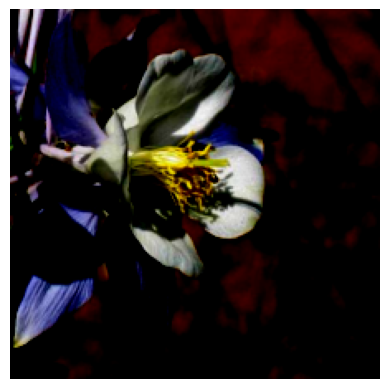

Actual Label: tree mallow
Predicted Label: tree mallow


In [31]:
predict(data_loaders['test'], model)



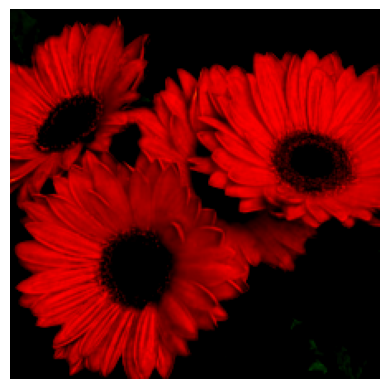

Actual Label: siam tulip
Predicted Label: siam tulip


In [32]:
predict(data_loaders['test'], model)

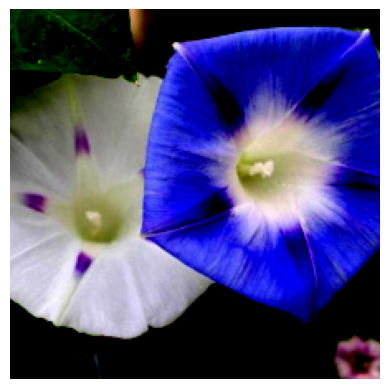

Actual Label: passion flower
Predicted Label: passion flower


In [33]:
predict(data_loaders['test'], model)

# plot the confusion matrix

In [34]:
def plot_confusion_matrix(model, dataloader):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import confusion_matrix

    device = next(model.parameters()).device

    # Set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    gt = pd.Series(all_labels, name='Ground Truth')
    predicted = pd.Series(all_preds, name='Predicted')

    confusion_matrix_df = pd.crosstab(gt, predicted, rownames=['Actual'], colnames=['Predicted'])

    fig, sub = plt.subplots(figsize=(14, 12))
    with sns.plotting_context("notebook"):
        idx = (confusion_matrix_df == 0)
        confusion_matrix_df[idx] = np.nan
        sns.heatmap(confusion_matrix_df, annot=True, ax=sub, linewidths=0.5, linecolor='lightgray', cbar=False)

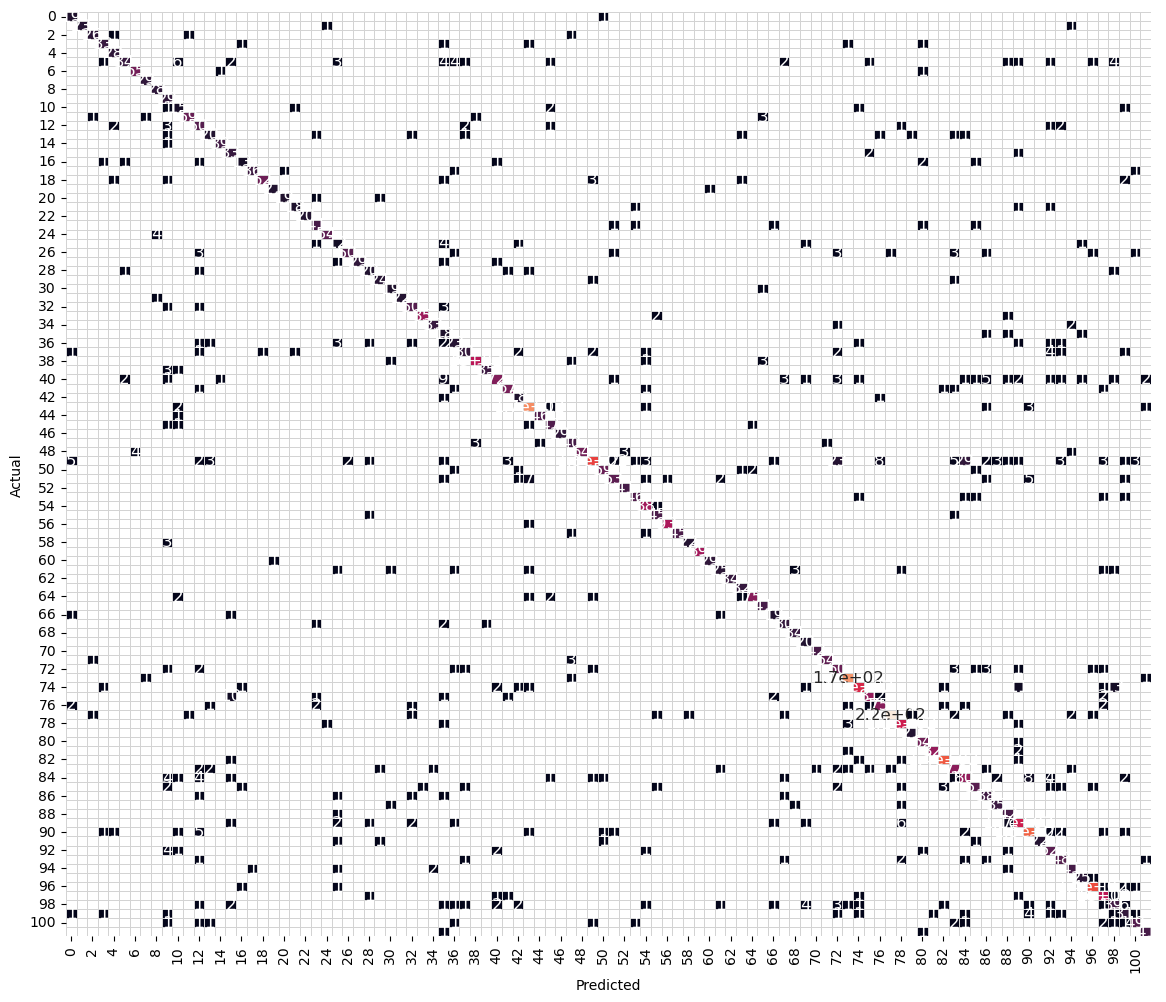

In [35]:
plot_confusion_matrix(model, data_loaders['test'])
